# Import libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Test on one dataset

## Our Dataset

In [9]:
# Load waypoints
file_name = "DL_C_F_BRTL_4"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line/{file_name}"
# output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop/{file_name}"

data_path = os.path.join(output_dir, "pose_waypoints_sampled_10hz_clean.csv") # A 10hz dataset
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv") # A 2.5hz dataset


# Set parameters
plot_2 = False # To plot the 2.5hz dataset on the same graph
speed_avg = False # To use the averaged linear velocity of last steps
avg_window_lin = 2 # The number of steps to average the linear velocity
pred_model = 'CV' # The prediction model to be used

In [10]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

print("Ground truth data loaded with the length: ", len(ground_truth))

Ground truth data loaded with the length:  24


## ETH Dataset

In [ ]:
# Load waypoints
file_name = "ETH_datasets"
output_dir = f"/home/sina/env_prediction_project/motion_predictor/{file_name}"

data_path = os.path.join(output_dir, "biwi_eth.csv") # A 10hz dataset
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv") # A 2.5hz dataset

# Set parameters
plot_2 = False # To plot the 2.5hz dataset on the same graph
speed_avg = False # To use the averaged linear velocity of last steps
pred_model = 'CV' # The prediction model to be used

In [ ]:
desired_ped_id = 201

# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ped_id = float(row["ped_id"])
        if ped_id == desired_ped_id:
            ground_truth.append([float(row["timestamp"]), ped_id, float(row["x"]), float(row["y"])])

# # Read the CSV file with a header
# with open(data_path_2, "r") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
# gt_array_2 = np.array(ground_truth_2)

print("Ground truth data loaded with the length: ", len(ground_truth))

In [5]:
# # DANGER!! INITIALIZED THE RESULTS_DF FROM THE BEGINNING

# # Make an empty dataframe to store the error values in next steps
# results_df = pd.DataFrame()

## Prediction Section

In [11]:
# Set prediction horizon
ph = 4

predictions = {}

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = {}

    velocities_linear = [None] * len(ped_data)

    # Compute linear velocities
    for i in range(len(ped_data) - 1):
        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]

        dt = t1 - t0
        if dt == 0:
            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
            continue

        vx = (x1 - x0) / dt
        vy = (y1 - y0) / dt

        velocities_linear[i + 1] = (vx, vy)  # Store tuple

    # Predict future positions
    for i in range(0, len(ped_data) - 1 - ph): # We need 1 first step to calculate omega, and the last ph steps cannot be a base for the prediction (no ground truth after that)

        # Take a window of previous linear velocities (ending at i+1)
        lin_window = velocities_linear[max(0, i + 1 - avg_window_lin + 1): i + 2]
        lin_window_valid = [v for v in lin_window if v is not None]

        if not lin_window_valid:
            print(f"Skipping prediction for pedestrian {ped_id} at index {i} due to insufficient velocity data")
            continue

        # Average vx, vy separately
        vx = np.mean([v[0] for v in lin_window_valid])
        vy = np.mean([v[1] for v in lin_window_valid])


        # Base time and position
        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
        dt1 = ped_data[i + 1, 0] - ped_data[i, 0]


        ### PREDICTION PART ###

        ## Step-by-step ph-step prediction   

        next_predicted_points = []

        x_base = x1
        y_base = y1

        for j in range(ph):

            dt_s = dt1

            x_next = x_base + vx * dt_s
            y_next = y_base + vy * dt_s

            # Update base for next step
            x_base = x_next
            y_base = y_next


            next_predicted_points.append([x_next, y_next])


        # # One-shot ph-step prediction
        # dt = ph * dt2
        
        # if abs(omega) > 1e-5:  # Non-zero turn rate
        #     radius = v / omega
        #     x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
        #     y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
        # else:  # Straight-line motion
        #     x_next = x2 + vx2 * dt
        #     y_next = y2 + vy2 * dt

        # Time of last predicted point (not used)
        t_next = t1 + ph * dt1  # Assuming uniform timestep

        ped_predictions[t1] = next_predicted_points

    for t1 in ped_predictions:
        if t1 not in predictions:
            predictions[t1] = {}
    
        # Store the prediction
        predictions[t1][ped_id] = ped_predictions[t1]

## Plot the results

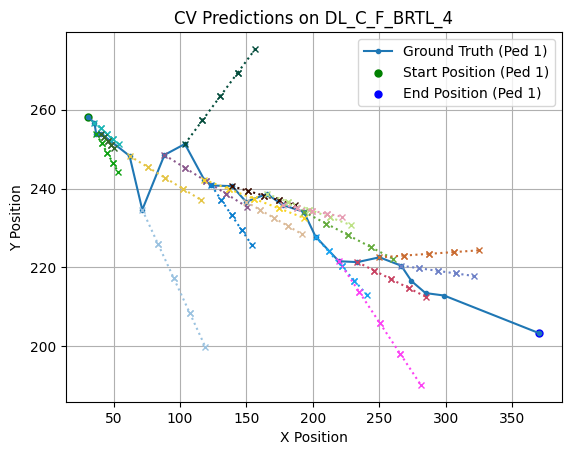

In [12]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# # Set the x and y axis limits
# plt.xlim(0, 500)
# plt.ylim(0, 400)

pedestrian_ids = np.unique(gt_array[:, 1])

# Plot ground truth trajectory (blue)
for ped_id in pedestrian_ids:
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        # Filter ground truth data for the pedestrian (second dataset)
        ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]
        x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]

        # Plot ground truth trajectory (second dataset)
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    for t1, ped_pred in predictions.items():
        for ped_id, pred in ped_pred.items():
            ped_data = gt_array[gt_array[:, 1] == ped_id]
            gt_timestamps = ped_data[:, 0]

            if t1 in gt_timestamps:
                idx = np.where(gt_timestamps == t1)[0][0]
                x_start = ped_data[idx, 2]
                y_start = ped_data[idx, 3]

                color = np.random.rand(3,)

                for point in pred:
                    x_pred, y_pred = point
                    plt.plot([x_start, x_pred], [y_start, y_pred],
                         color=color, linestyle='dotted',
                         marker="x", markersize=4)
                    
                    x_start, y_start = x_pred, y_pred
                    # break


    ## THESE PLOTS ARE NOT WORKING ANYMORE
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other, only useful for one-step prediction
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
    
# plt.gca().invert_yaxis()  # Invert Y to match video coordinates
# plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"{pred_model} Predictions on {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

## Calculate FDE & ADE

In [13]:
error_fde = []
error_fde_normal = []

error_ade = []
error_ade_normal = []

i = 0
for t1, ped_dict in predictions.items():
    for ped_id, pred_list in ped_dict.items():
        # Skip empty predictions
        if len(pred_list) < 1:
            continue


        # Get corresponding ground truth for ped_id
        ped_data = gt_array[gt_array[:, 1] == ped_id]
        gt_timestamps = ped_data[:, 0]


        if t1 not in gt_timestamps:
            print("Unexpected ERROR! The prediction base timestep is not present in ground truth")
            continue

        start_idx = np.where(gt_timestamps == t1)[0][0]
        target_idx = start_idx + ph


        if target_idx >= len(ped_data):
            print('Not enough GT data to evaluate')
            continue

        # --- FDE ---

        # Get the last predicted point (FDE)
        pred_fde = np.array(pred_list[-1])
        gt_fde = np.array([ped_data[target_idx, 2], ped_data[target_idx, 3]])
        dist_fde = np.linalg.norm(pred_fde - gt_fde)
        error_fde.append(dist_fde)

        # Normalized error over ground truth path (t1 to t_target)
        steps_size_fde = 0

        for j in range(1, ph + 1):
            if start_idx + j >= len(ped_data):
                break
            step_start = np.array([ped_data[start_idx + j - 1, 2], ped_data[start_idx + j - 1, 3]])
            step_end = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
            steps_size_fde += np.linalg.norm(step_end - step_start)

        if steps_size_fde > 0:
            error_fde_normal.append(dist_fde / steps_size_fde)

        # --- ADE ---

        total_dist = 0
        total_dist_normalized = 0
        valid_steps = 0

        for j in range(ph):
            if start_idx + j + 1 >= len(ped_data) or j >= len(pred_list):
                break

            pred_step = np.array(pred_list[j])
            gt_step = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
            dist_step = np.linalg.norm(pred_step - gt_step)
            total_dist += dist_step

            # Normalize by step size between GT positions
            step_start = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
            step_end = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
            step_size = np.linalg.norm(step_end - step_start)

            if step_size > 0:
                total_dist_normalized += dist_step / step_size

            valid_steps += 1

        if valid_steps > 0:
            error_ade.append(total_dist / valid_steps)
            error_ade_normal.append(total_dist_normalized / valid_steps)



        i += 1

# Compute and print averages
fde_avg = np.average(error_fde)
ade_avg = np.average(error_ade)
print('Final displacement error (FDE): {:.3f}'.format(fde_avg))
print('Average displacement error (ADE): {:.3f}'.format(ade_avg))

fde_avg_normal = np.average(error_fde_normal)
ade_avg_normal = np.average(error_ade_normal)
print('Normalized FDE: {:.3f}'.format(fde_avg_normal))
print('ADE Normalized: {:.3f}'.format(ade_avg_normal))


Final displacement error (FDE): 24.007
Average displacement error (ADE): 15.826
Normalized FDE: 0.398
ADE Normalized: 1.189


# Test on multiple dataset

In [ ]:
speed_avg = True
ph = 4

# Directories for datasets
base_dirs = [
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Square Path",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"
]

results = []

for base_dir in base_dirs:
    for root, dirs, files in os.walk(base_dir):

        dataset_name = root.split("/")[-1]
        if dataset_name.startswith('x_'):
            continue

        for file in files:

            if file.endswith("_raw.csv"):
                continue

            if ph == 4 and file.endswith("_2.5hz_clean.csv"):
                continue
            
            data_path = os.path.join(root, file)

            # Load data and calculate prediction error
            try:
                # Parse ground truth data
                ground_truth = []

                # Read the CSV file with a header
                with open(data_path, "r") as csvfile:
                    reader = csv.DictReader(csvfile)
                    for row in reader:
                        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                        
                gt_array = np.array(ground_truth)

                # Group data by pedestrian ID (column 1)
                pedestrian_ids = np.unique(gt_array[:, 1])

                predictions = {}

                for ped_id in pedestrian_ids:
                    # Filter data for the current pedestrian
                    ped_data = gt_array[gt_array[:, 1] == ped_id]
                    
                    # Initialize predictions for this pedestrian
                    ped_predictions = {}
                    
                    for i in range(0, len(ped_data) - 1 - ph):
                        # Extract current and next timestep data
                        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                        t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]
                        
                        dt1 = t1 - t0
                        dt2 = t2 - t1

                        if dt1 == 0 or dt2 == 0:
                            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
                            continue  # Avoid divide-by-zero
                        
                        # Calculate velocity (vx, vy)
                        vx1 = (x1 - x0) / dt1
                        vy1 = (y1 - y0) / dt1

                        vx2 = (x2 - x1) / dt2
                        vy2 = (y2 - y1) / dt2

                        # Compute headings
                        theta1 = np.arctan2(y1 - y0, x1 - x0)
                        theta2 = np.arctan2(y2 - y1, x2 - x1)

                        # Compute yaw rate and velocity
                        dtheta = theta2 - theta1
                        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize to the range [-pi, pi]
                        omega = dtheta / dt2

                        # Compute average velocity if the flag is True
                        if speed_avg and i > 0:
                            t00, x00, y00 = ped_data[i-1, 0], ped_data[i-1, 2], ped_data[i-1, 3]
                            vx_0 = (x0 - x00) / (t0 - t00)
                            vy_0 = (y0 - y00) / (t0 - t00)

                            vx1 = (vx1 + vx_0) / 2
                            vy1 = (vy1 + vy_0) / 2


                        ### PREDICTION PART ###

                        ## Step-by-step ph-step prediction   

                        next_predicted_points = []

                        x_base = x1
                        y_base = y1


                        for j in range(ph):

                            dt_s = dt1

                            x_next = x1 + vx1 * (j + 1) * dt_s
                            y_next = y1 + vy1 * (j + 1) * dt_s


                            next_predicted_points.append([x_next, y_next])


                        # Time of last predicted point (not used)
                        t_next = t1 + ph * dt1  # Assuming uniform timestep
            
                        # Store the prediction
                        ped_predictions[t1] = next_predicted_points
                        

                    for t1 in ped_predictions:
                        if t1 not in predictions:
                            predictions[t1] = {}
                    
                        # Store the prediction
                        predictions[t1][ped_id] = ped_predictions[t1]

                error_fde = []
                error_fde_normal = []

                error_ade = []
                error_ade_normal = []

                i = 0
                for t1, ped_dict in predictions.items():
                    for ped_id, pred_list in ped_dict.items():
                        # Skip empty predictions
                        if len(pred_list) < 1:
                            continue

                        # Get corresponding ground truth for ped_id
                        ped_data = gt_array[gt_array[:, 1] == ped_id]
                        gt_timestamps = ped_data[:, 0]


                        if t1 not in gt_timestamps:
                            print("Unexpected ERROR! The prediction base timestep is not present in ground truth")
                            continue

                        start_idx = np.where(gt_timestamps == t1)[0][0]
                        target_idx = start_idx + ph


                        if target_idx >= len(ped_data):
                            print('Not enough GT data to evaluate')
                            continue

                        # --- FDE ---

                        # Get the last predicted point (FDE)
                        pred_fde = np.array(pred_list[-1])
                        gt_fde = np.array([ped_data[target_idx, 2], ped_data[target_idx, 3]])
                        dist_fde = np.linalg.norm(pred_fde - gt_fde)
                        error_fde.append(dist_fde)

                        # Normalized error over ground truth path (t1 to t_target)
                        steps_size_fde = 0

                        for j in range(1, ph + 1):
                            if start_idx + j >= len(ped_data):
                                break
                            step_start = np.array([ped_data[start_idx + j - 1, 2], ped_data[start_idx + j - 1, 3]])
                            step_end = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
                            steps_size_fde += np.linalg.norm(step_end - step_start)

                        if steps_size_fde > 0:
                            error_fde_normal.append(dist_fde / steps_size_fde)


                        # --- ADE ---

                        total_dist = 0
                        total_dist_normalized = 0
                        valid_steps = 0

                        for j in range(ph):
                            if start_idx + j + 1 >= len(ped_data) or j >= len(pred_list):
                                break

                            pred_step = np.array(pred_list[j])
                            gt_step = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
                            dist_step = np.linalg.norm(pred_step - gt_step)
                            total_dist += dist_step

                            # Normalize by step size between GT positions
                            step_start = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
                            step_end = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
                            step_size = np.linalg.norm(step_end - step_start)

                            if step_size > 0:
                                total_dist_normalized += dist_step / step_size

                            valid_steps += 1

                        if valid_steps > 0:
                            error_ade.append(total_dist / valid_steps)
                            error_ade_normal.append(total_dist_normalized / valid_steps)



                        i += 1
                
                fde_avg = np.average(error_fde)
                ade_avg = np.average(error_ade)

                fde_avg_normal = np.average(error_fde_normal)
                ade_avg_normal = np.average(error_ade_normal)

                
                # Append result
                results.append({
                    "Dataset Name": dataset_name,
                    "Path Type": dataset_name[:4],
                    "Acceleration Type": dataset_name.split("_")[2],
                    "Path Direction": dataset_name.split("_")[3],
                    "Path Number": dataset_name.split("_")[4],
                    "Sample Rate": file.split("_")[-2],
                    "Prediction Horizon": ph,
                    "Prediction Model": pred_model,
                    "Avg. Lin. Vel.": speed_avg,
                    "Average ADE": ade_avg,
                    "Average ADE (Normalized)": ade_avg_normal,
                    "Average FDE": fde_avg,
                    "Average FDE (Normalized)": fde_avg_normal
                })

                # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
            except Exception as e:
                print(f"Error processing {dataset_name} with {file}: {e}")

In [20]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


,Dataset Name,Path Type,Acceleration Type,Path Direction,Path Number,Sample Rate,Prediction Horizon,Prediction Model,Avg. Lin. Vel.,Average ADE,Average ADE (Normalized),Average FDE,Average FDE (Normalized)
0,VL_C_F_TD_3,VL_C,F,TD,3,full,4,CV,False,10.610816,3.987746,17.300369,1.005540
1,VL_C_F_TD_3,VL_C,F,TD,3,10hz,4,CV,False,22.825323,4.625405,37.339447,0.995166
2,VL_C_F_BU_5,VL_C,F,BU,5,full,4,CV,False,10.443218,2.707653,18.224721,0.961869
3,VL_C_F_BU_5,VL_C,F,BU,5,10hz,4,CV,False,31.477282,4.497487,47.276116,0.922052
4,VL_C_F_BU_6,VL_C,F,BU,6,full,4,CV,False,11.665653,3.470563,18.802438,0.843404
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,CP_C_F_CCW_2,CP_C,F,CCW,2,10hz,4,CV,True,22.074105,3.660401,32.766066,0.886578
1026,CP_C_F_CCW_3,CP_C,F,CCW,3,full,4,CV,True,10.018734,2.532712,16.197457,0.819151
1027,CP_C_F_CCW_3,CP_C,F,CCW,3,10hz,4,CV,True,25.323774,3.557619,38.037703,0.824603
1028,CP_C_A_CW_1,CP_C,A,CW,1,full,4,CV,True,10.466486,3.126738,16.736470,0.840685


In [21]:
results_df.to_csv("results_cv_2.csv", index=False)

In [25]:
results_df_filtered = results_df[
    (results_df['Sample Rate'].isin(['10hz'])) & 
    (results_df['Prediction Horizon'] == 4) & 
    (results_df['Acceleration Type'] == 'F')
    ]

# Same path type for all straight lines
results_df_filtered.loc[results_df_filtered['Path Type'].isin(['VL_C', 'HL_C', 'DL_C']), 'Path Type'] = 'Straight'

results_df_filtered.groupby([
    # 'dataset_name',
    'Path Type',
    'Sample Rate',
    'Prediction Horizon',
    'Avg. Lin. Vel.',
    'Prediction Model'
]).agg({
    'Average ADE': ['mean', 'std'],
    'Average ADE (Normalized)': ['mean', 'std'],
    'Dataset Name': 'size'
}).reset_index()

Path Type Sample Rate Prediction Horizon Avg. Lin. Vel. Prediction Model  \
                                                                             
0      CP_C        10hz                  4          False               CV   
1      CP_C        10hz                  4           True               CV   
2      IL_C        10hz                  4          False               CV   
3      IL_C        10hz                  4           True               CV   
4      SP_C        10hz                  4          False               CV   
5      SP_C        10hz                  4           True               CV   
6  Straight        10hz                  4          False               CV   
7  Straight        10hz                  4           True               CV   

  Average ADE           Average ADE (Normalized)           Dataset Name  
         mean       std                     mean       std         size  
0   27.015511  2.521800                 4.069592  0.797928            8  
1   25.294425  3.125987                 3.839141  0.875656            8  
2   22.778275  3.072504                 4.204307  0.544598           11  
3   20.915210  2.787482                 3.865923  0.516416           11  
4   21.648056  3.884224                 4.337740  1.370527            8  
5   19.967720  3.530707                 4.125540  1.266387            8  
6   25.839237  6.742731                 3.472996  2.151903           36  
7   23.104440  6.853853                 3.145600  2.090684           36